In [1]:
import os
import tempfile
import torch
from pathlib import Path
from csv import writer
from torch.utils.data import DataLoader
from data_utils.csv_dataloader import FlowPicCSVDataset
from tqdm import trange, tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
columns = ['timeSec1970', 'timeMs', 'appId', 'ipAddrClient', 'ipAddrServer',
           'portClient', 'portServer', 'protocol', 'ppiLen', 'ppi-pdt',
           'ppi-pd', 'ppi-ps', 'ppi-paux']
csv_path = Path('/home/anatbr/dataset/Allot/ver02 - Location 01 - 2024.09.06-09.csv G Z')
n_rows_per_ds = 1e4

# get CSVs

In [7]:
ranges = []
for i in trange(200):
    df = pd.read_csv(csv_path, nrows=n_rows_per_ds, skiprows=int(n_rows_per_ds * (i + 1)))
    df.columns = columns
    df['absoluteTime'] = pd.to_datetime(df['timeSec1970'], unit='s')
    assert df.absoluteTime.is_monotonic_increasing
    df.to_csv(f'data/allot_chunks_csvs/chunk_{i:03d}.csv', index=False)
    # print(df.absoluteTime.min(), df.absoluteTime.max())
    ranges.append((df.absoluteTime.min(), df.absoluteTime.max()))
    

100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


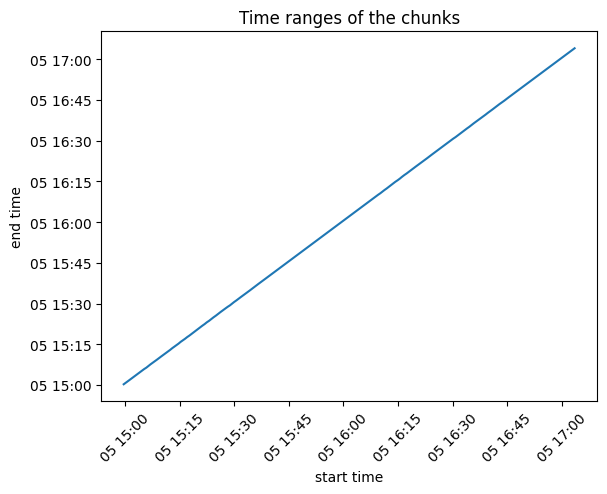

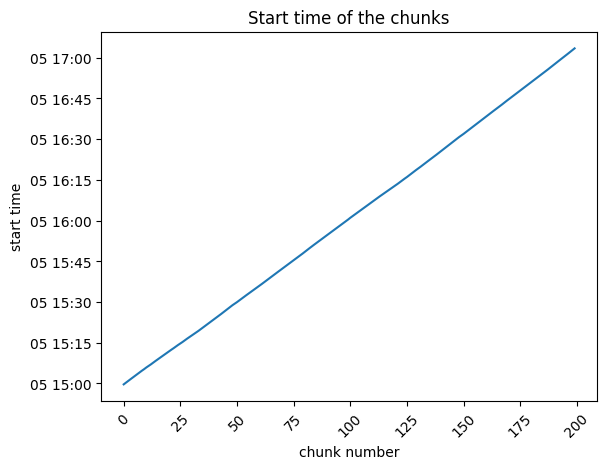

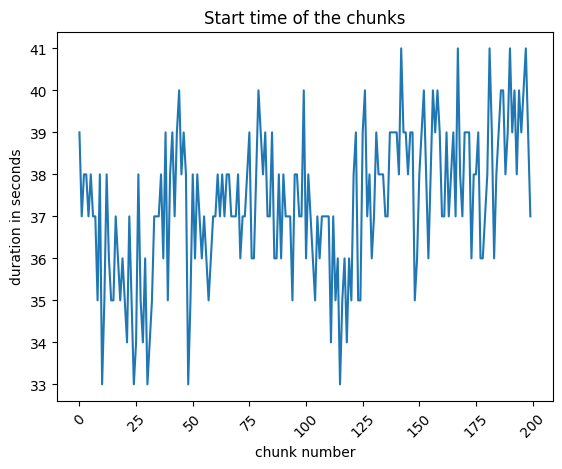

In [17]:
plt.plot([r[0] for r in ranges], [r[1] for r in ranges])
plt.xlabel('start time')
plt.ylabel('end time')
plt.title('Time ranges of the chunks')
plt.xticks(rotation=45)
plt.show()


plt.plot([r[0] for r in ranges])
plt.xlabel('chunk number')
plt.ylabel('start time')
plt.title('Start time of the chunks')
plt.xticks(rotation=45)
plt.show()

plt.plot([(r[1]  - r[0]).total_seconds() for r in ranges])
plt.xlabel('chunk number')
plt.ylabel('duration in seconds')
plt.title('Start time of the chunks')
plt.xticks(rotation=45)
plt.show()